In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Create training and test set with 500 examples of classes 5 and 8 respectively and change labels to 0 and 1. At the same time flip 30% of the labels.

In [3]:
train_set = [ex for ex in train_dataset if ex[1]==5][:500] + [ex for ex in train_dataset if ex[1]==8][:500]
test_set = [ex for ex in test_dataset if ex[1]==5][:500] + [ex for ex in test_dataset if ex[1]==8][:500]

In [4]:
train_set_01_images = []
test_set_01_images = []
train_set_01_labels = []
test_set_01_labels = []
num_flips = 500//3 #num_flips=0 to have no flips
for i,ex_tr in enumerate(train_set): # [0,499] ->5, [500,999] ->8
    ex_tr = list(ex_tr)
    if ex_tr[1]==5:
        if i<num_flips: # 0-30% of 5s(0-499) are flipped to 8s, 
            ex_tr[1]=1
            # 1 is the label for 8s
            # 0 is the label for 5s
        else: 
            ex_tr[1]=0
    else: 
        if i<num_flips+500: # 0-30% of 8s(500-999) are flipped to 5s
            ex_tr[1]=0
        else: 
            ex_tr[1]=1
    train_set_01_images.append(ex_tr[0])
    train_set_01_labels.append(ex_tr[1])
    
for ex_te in test_set:
    ex_te = list(ex_te)
    if ex_te[1]==5:
        ex_te[1]=0
    else: 
        ex_te[1]=1
    test_set_01_images.append(ex_te[0])
    test_set_01_labels.append(ex_te[1])
train_set_01_images = torch.stack(train_set_01_images)  # why stack? anwser: to make it a tensor, and the shape is (1000, 1, 28, 28)
train_set_01_images = train_set_01_images.view(-1, 28*28) # 1000, 784

test_set_01_images = torch.stack(test_set_01_images)
test_set_01_images = test_set_01_images.view(-1, 28*28)

train_set_01_labels = torch.tensor(train_set_01_labels)
test_set_01_labels = torch.tensor(test_set_01_labels) 

# shuffle training set
n_sample = len(train_set_01_images)
np.random.seed(0)
order = np.random.permutation(n_sample)
train_set_01_images = train_set_01_images[order]
train_set_01_labels = train_set_01_labels[order]

In [5]:
print("size train set:", train_set_01_images.shape)
print("size test set:", test_set_01_images.shape)

size train set: torch.Size([1000, 784])
size test set: torch.Size([1000, 784])


## logistic regression

In [6]:
# def sigmoid(X):
#     return 1/(1+torch.exp(-X))

# def f(X,theta): # x 1*784, theta 784*1
#     return sigmoid(torch.matmul(X,theta))

# def loss(X,y,theta):
#     epsilon = 1e-8 # to avoid nan
#     X = X.type(torch.float)
#     y = y.type(torch.float)
#     loss1 = -torch.matmul(y,torch.log(f(X,theta)+epsilon)) - torch.matmul((1-y),torch.log(1-f(X,theta)+epsilon))
#     return loss1

# def loss_grad(X,y,theta):
#     X = X.type(torch.float)
#     y = y.type(torch.float)
#     return torch.matmul(X.T, f(X,theta)-y).sum(1).view(-1,1)


In [7]:
# max_epochs = 10000
# step_size = 0.0000001
# theta1 = torch.ones(28*28,1)

# for i in range(max_epochs): 
#     grad = loss_grad(train_set_01_images, train_set_01_labels, theta1)
#     tmp = theta1
#     theta1 = theta1 - step_size * grad
#     print(loss(train_set_01_images, train_set_01_labels, theta1))


In [8]:
X = train_set_01_images.type(torch.float)
X.shape

torch.Size([1000, 784])

In [9]:

class Net(nn.Module):
    def __init__(self,input_size,output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        output = torch.sigmoid(self.fc1(x))
        return output
    
net = Net(28*28,1)

import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_errors = []
test_errors = []

train_accs = []
test_accs = []


X = train_set_01_images.type(torch.float)
y = train_set_01_labels.type(torch.float).view(-1,1)

X_test = test_set_01_images.type(torch.float)
y_test = test_set_01_labels.type(torch.float).view(-1,1)

max_epochs = 10000
for epochs in range(max_epochs):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1,1), y)
    loss.backward()
    optimizer.step()

    # store training and test errors/accuracy
    train_acc = ((outputs>0.5).type(torch.int32)==y.type(torch.int32)).type(torch.float).mean() 
    train_accs.append(train_acc)
    
    outputs_test = net(X_test)
    test_acc = ((outputs_test>0.5).type(torch.int32)==y_test.type(torch.int32)).type(torch.float).mean()
    test_accs.append(test_acc)
    
    train_errors.append(loss.item())
    test_errors.append(criterion(outputs_test.view(-1,1), y_test).item())

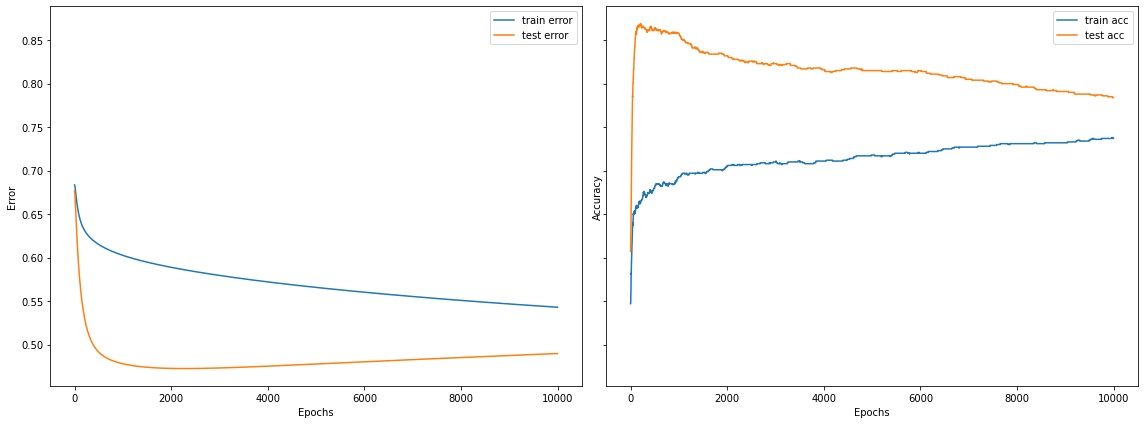

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax1.plot(train_errors, label='train error')
ax1.plot(test_errors, label='test error')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Error')
ax1.legend()

# Plotting accuracies
ax2.plot(train_accs, label='train acc')
ax2.plot(test_accs, label='test acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [15]:
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(2*28*28, 1)
    
    def forward(self, x):
        output = torch.sigmoid(self.fc1(x))
        return output
    
net = Net1()
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

train_errors = []
test_errors = []

train_accs = []
test_accs = []

F1 = torch.randn(2*784,784)
X = train_set_01_images.type(torch.float)
X = F.relu(torch.matmul(F1,X.T).T)
y = train_set_01_labels.type(torch.float).view(-1,1)

X_test = test_set_01_images.type(torch.float)
X_test = F.relu(torch.matmul(F1,X_test.T).T)
y_test = test_set_01_labels.type(torch.float).view(-1,1)

max_epochs = 10000
for epochs in range(max_epochs):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1,1), y)
    loss.backward()
    optimizer.step()

    # store training and test errors/accuracy
    train_acc = ((outputs>0.5).type(torch.int32)==y.type(torch.int32)).type(torch.float).mean() 
    train_accs.append(train_acc)
    
    outputs_test = net(X_test)
    test_acc = ((outputs_test>0.5).type(torch.int32)==y_test.type(torch.int32)).type(torch.float).mean()
    test_accs.append(test_acc)
    
    train_errors.append(loss.item())
    test_errors.append(criterion(outputs_test.view(-1,1), y_test).item())

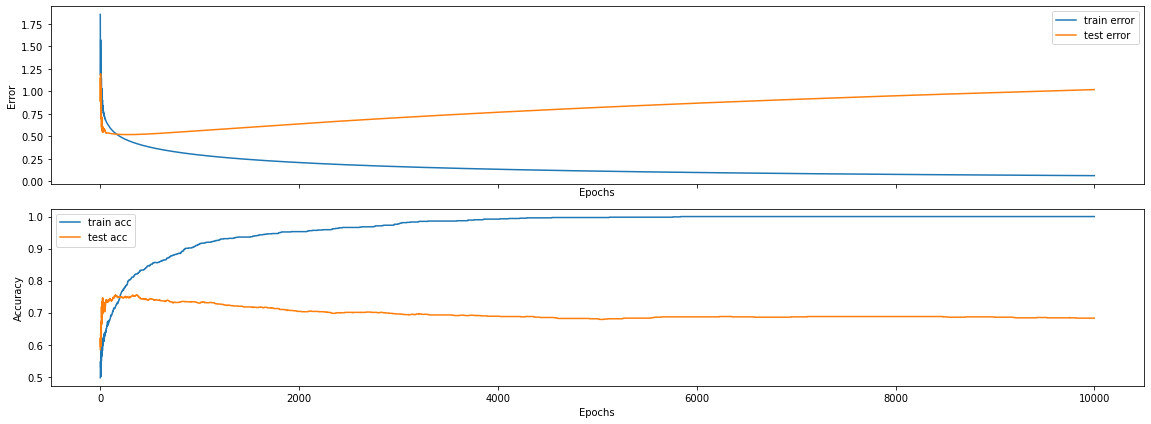

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

ax1.plot(train_errors, label='train error')
ax1.plot(test_errors, label='test error')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Error')
ax1.legend()

# Plotting accuracies
ax2.plot(train_accs, label='train acc')
ax2.plot(test_accs, label='test acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()